# Bead-spring model

In [1]:
import sys

sys.path.append('..')

In [2]:
from argparse import Namespace

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from misc.sampler import CartesianSampler
from toy.bead_spring import del_medium_etpy, del_shannon_etpy, simulation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%config InlineBackend.figure_format = 'retina'

## NEEP 

In [3]:
class NEEP(nn.Module):
    def __init__(self, opt):
        super(NEEP, self).__init__()
        self.h = nn.Sequential(
            nn.Linear(2*opt.n_input, opt.n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(opt.n_hidden, opt.n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(opt.n_hidden, opt.n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(opt.n_hidden, 1)
        )

    def forward(self, s1, s2):
        x = torch.cat([s1, s2], dim=-1)
        _x = torch.cat([s2, s1], dim=-1)
        # Equation (1) in the paper
        return self.h(x) - self.h(_x) 

### Training Algorithm

In [4]:
def train(opt, model, optim, trajs, sampler):
    model.train()
    batch, next_batch = next(sampler)

    s_prev = trajs[batch].to(opt.device)
    s_next = trajs[next_batch].to(opt.device)
    ent_production = model(s_prev, s_next)
    optim.zero_grad()
    
    # The objective function J. Equation (2)
    loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss.backward()
    optim.step()
    return loss.item()


def validate(opt, model, trajs, sampler):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch, next_batch in sampler:
            s_prev = trajs[batch].to(opt.device)
            s_next = trajs[next_batch].to(opt.device)
            
            ent_production = model(s_prev, s_next)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            loss += (- ent_production + torch.exp(-ent_production)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(trajs.shape[0], trajs.shape[1]-1)
    return ret, loss

### Hyper-parameters

In [5]:
opt = Namespace()
opt.device = 'cuda:0' 
opt.batch_size = 4096
opt.test_batch_size = 50000
opt.n_input = 2
opt.n_hidden = 512

opt.lr = 0.0001
opt.wd = 5e-5

opt.record_freq = 1000

# Trajectory sampling

In [6]:
opt.M = 1000          # number of trajectories
opt.L = 5000          # lenth of a trjectory 
opt.n_beads = 2       # number of beads
opt.Tc = 1            # cold temperature
opt.Th = 10           # hot temperature 
opt.time_step = 0.01  # time step size for Langevin simulation

trajs = simulation(opt.M, opt.L, opt.n_beads, opt.Tc, opt.Th, opt.time_step, seed=0)
test_trajs = simulation(opt.M, opt.L, opt.n_beads, opt.Tc, opt.Th, opt.time_step, seed=1)

trajs_t = torch.from_numpy(trajs).float()
test_trajs_t = torch.from_numpy(test_trajs).float()

[ 1. 10.]
MultiBead Simulation Starts with seed= 0
[ 1. 10.]
MultiBead Simulation Starts with seed= 1


## Build model & Training

In [7]:
model = NEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)

train_sampler = CartesianSampler(opt.M, opt.L, opt.batch_size, device=opt.device)
test_sampler = CartesianSampler(opt.M, opt.L, opt.test_batch_size, device=opt.device, train=False)

# NEEP outputs before training begin
preds_untrained, _ = validate(opt, model, test_trajs_t, test_sampler)

# Analytic EP
ents = del_medium_etpy(test_trajs[:2], 1, 10) + del_shannon_etpy(test_trajs[:2], 1, 10)

In [8]:
def plot_scatter(pred, ent):
    pred_rate, _, r_value, pvalue, _  = stats.linregress(ent, pred)
    plt.figure(figsize=(4,4), dpi=100)
    sns.regplot(ent, pred,
                color='C3', 
                line_kws={
                    'lw':1.5,
                    'label':'$R^2=%.4f$ p-value: %.4f' %(r_value**2, pvalue)},
                scatter_kws={
                    'color':'grey', 
                    'alpha':0.3, 
                    's':3, 
                    'rasterized':True})
    plt.xlabel('$\Delta S$', fontsize=12)
    plt.ylabel('$\Delta S_{\\theta}$', fontsize=12)
    plt.legend()

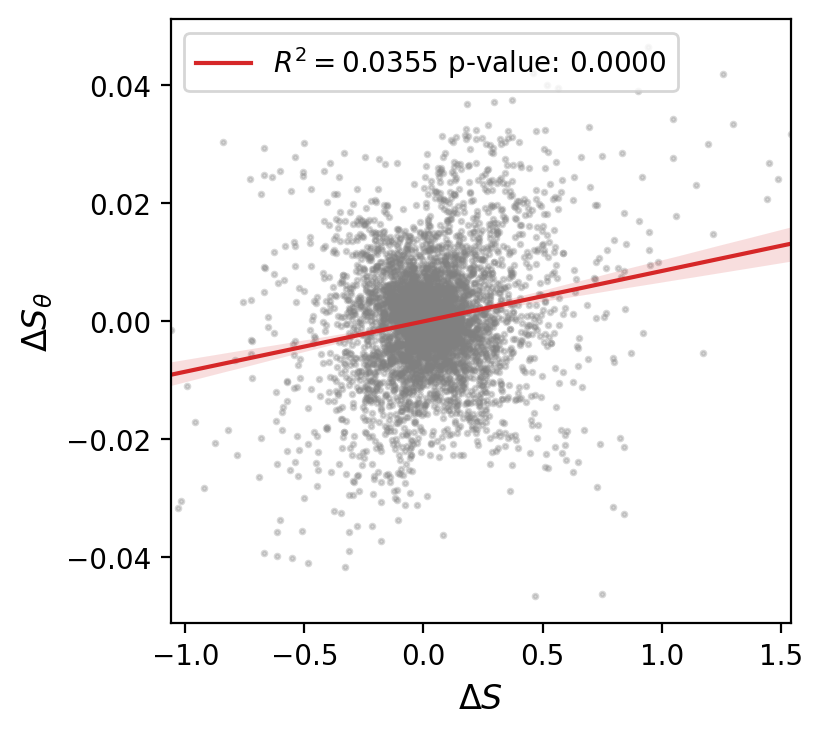

In [9]:
pred = preds_untrained[1]
ent = ents[1]
plot_scatter(pred, ent)

In [10]:
opt.n_iter = 10000 # number of training iteration

for i in tqdm(range(1, opt.n_iter + 1)):
    train(opt, model, optim, trajs_t, train_sampler)

In [11]:
preds, _ = validate(opt, model, test_trajs_t, test_sampler)

# Analytic EP
ents = del_medium_etpy(test_trajs[:100], opt.Tc, opt.Th) + del_shannon_etpy(test_trajs[:100], opt.Tc, opt.Th)

## Results
### Entropy production (EP)

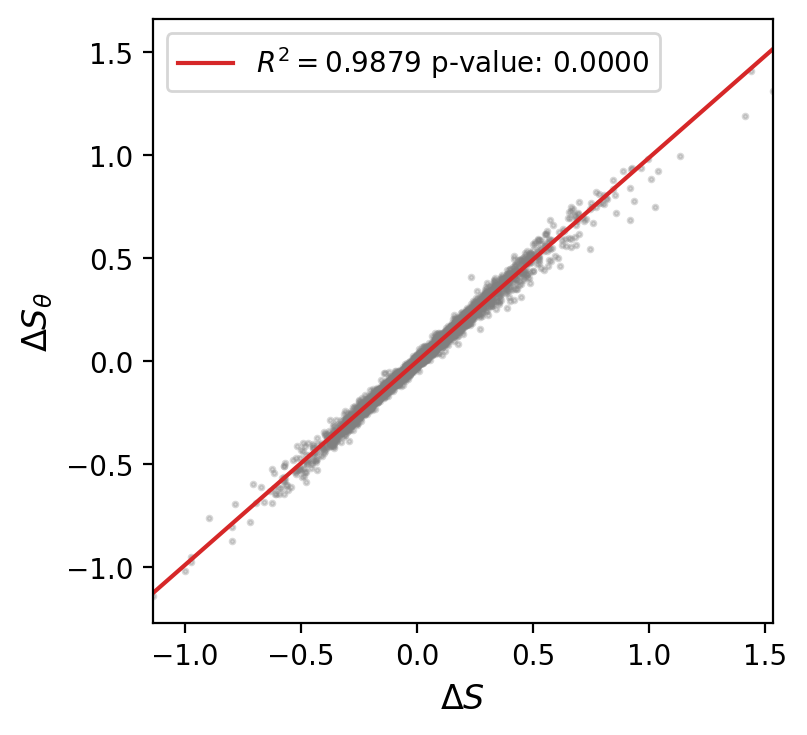

In [12]:
idx = 0
ent = ents[idx]
pred = preds[idx]
plot_scatter(pred, ent)

### Single trajectory EP & Ensemble average EP

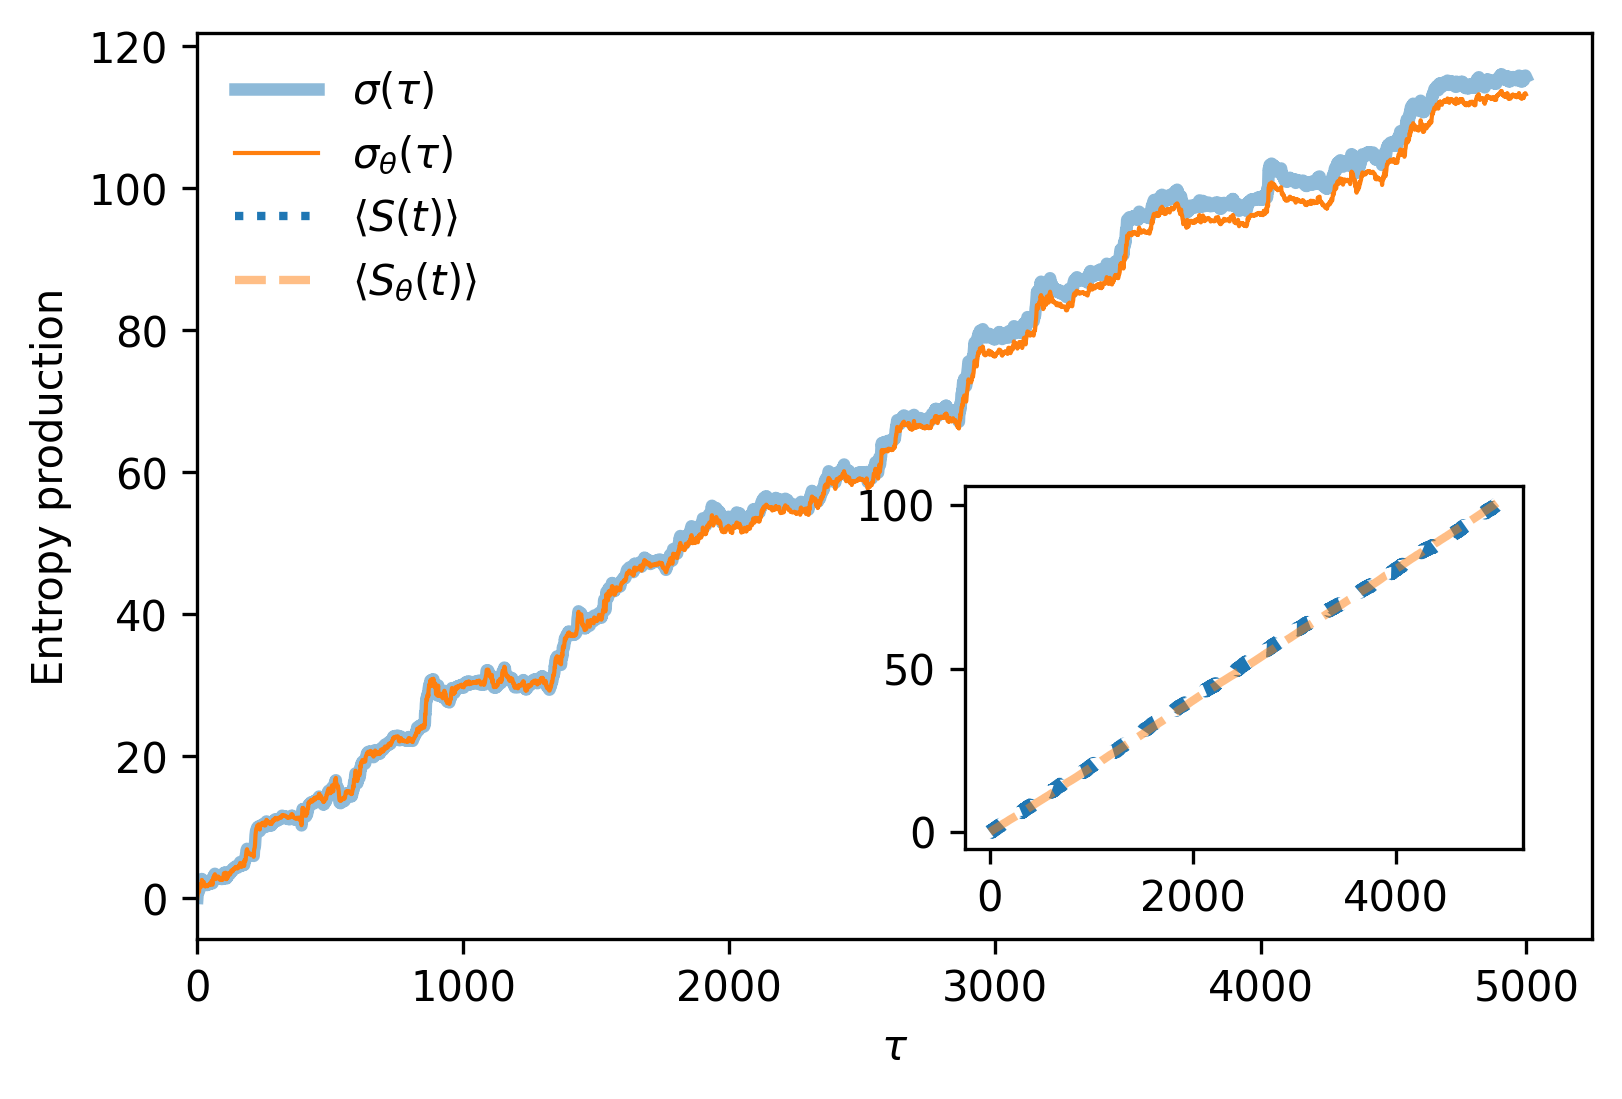

In [13]:
idx = 0 #np.random.randint(0, 1000)
ent = ents[idx]
pred = preds[idx]

cum_preds = np.cumsum(preds, axis=1)
cum_ents = np.cumsum(ents, axis=1)


plt.figure(dpi=150)
plt.plot(np.cumsum(ent), lw=3, alpha=0.5,color='C0', 
         label='$\sigma(\\tau)$')
plt.plot(np.cumsum(pred), lw=1, color='C1',
         label='$\sigma_{\\theta}(\\tau)$')
plt.plot([], ls = 'dotted', color='C0', lw=2, 
         label='$\\left<S(t)\\right>$')
plt.plot([], lw=2, ls = '--', alpha=0.5, color='C1',
         label='$\\left<S_{\\theta}(t)\\right>$')

plt.xlim(0)
plt.xlabel('$\\tau$')
plt.ylabel('Entropy production')
plt.legend(frameon = False)
ax = plt.gca()
axins = ax.inset_axes([0.55, 0.1, 0.4, 0.4])
axins.plot(cum_ents.mean(axis=0), ls = 'dotted', color='C0', lw=3.5, 
           label='$\\left<S(t)\\right>$')
axins.plot(cum_preds.mean(axis=0), lw=2, ls = '--', alpha=0.5, 
           label='$\\left<S_{\\theta}(t)\\right>$', color='C1')
plt.xlim(0)

plt.show()